In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font='IPAGothic')
import statsmodels.api as sm


# Reading required file

In [20]:
price=pd.read_csv('Data/pricing.csv',parse_dates=['DATE'])
mark=pd.read_csv('Data/marketing.csv',parse_dates=['DATE'])
tran=pd.read_csv('Data/transaction.csv',parse_dates=['DATE'])

In [21]:
tran.head(2)# Transaction data

,DATE,USERID,PRICE,UNITS,TOTAL
0,2015-04-03,1052,4.0,1,4.0
1,2015-04-03,1059,4.0,2,8.0


In [22]:
price.head(2) # Pricing data

,DATE,PRICE,PRICINGPOLICY
0,2015-04-03,4.0,LIST PRICE
1,2015-04-04,4.0,LIST PRICE


In [23]:
mark.head(2) # Marketing data

,DATE,MARKETINGEVENT
0,2015-04-03,LAUNCH CAMPAIGN
1,2015-05-11,MAJOR EVENT SPONSORSHIP


In [24]:

tran=tran.groupby([ pd.Grouper(key='DATE', freq='D')])['TOTAL'].sum().reset_index()
df=tran
df['PRICE']=price['PRICE'][:len(tran)]
df=df.set_index('DATE')
mark['MARKETINGEVENT'].value_counts()


MINOR EVENT SPONSORSHIP    10
MAJOR EVENT SPONSORSHIP     8
MINOR ADVERTISING BUY       6
MAJOR ADVERTISING BUY       3
LAUNCH CAMPAIGN             1
Name: MARKETINGEVENT, dtype: int64

In [25]:
data = pd.merge(price,mark, on=['DATE'], how='left')
data.fillna(method='ffill', inplace=True)
temp_tran=tran[['DATE','TOTAL']]
data=pd.merge(data,temp_tran, on=['DATE'], how='left')

In [26]:
dff=data[:len(tran)].set_index('DATE')

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


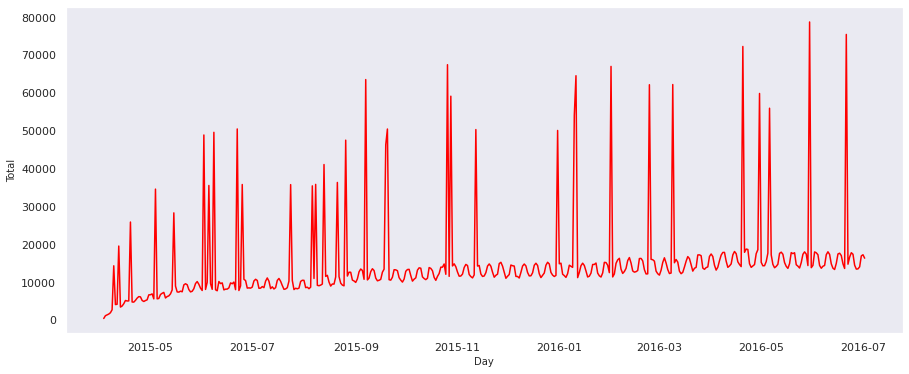

In [27]:
fig = plt.figure(figsize=(15,6))
plt.plot(dff['TOTAL'], color='red')
plt.xlabel('Day', fontsize=10)
plt.ylabel('Total', fontsize=10)
plt.grid()
plt.show()

C:\Users\nikit\AppData\Local\Temp/ipykernel_16408/2314494129.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(np.log(dff.TOTAL.dropna()),freq=7)
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


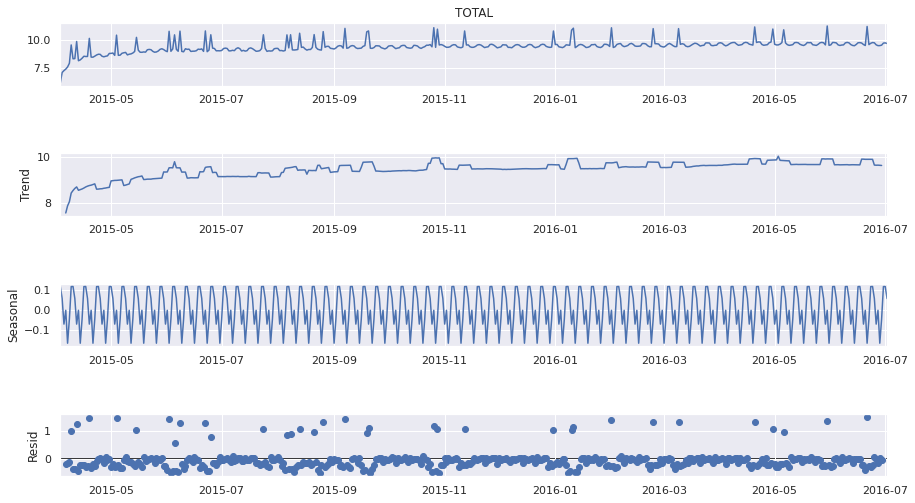

In [28]:
res = sm.tsa.seasonal_decompose(np.log(dff.TOTAL.dropna()),freq=7)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [29]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(np.log(dff.TOTAL), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: -3.8682816040825885
n_lags: 0.002281082165899613
p-value: 0.002281082165899613
Critial Values:
   1%, -3.445231637930579
Critial Values:
   5%, -2.8681012763264233
Critial Values:
   10%, -2.5702649212751583


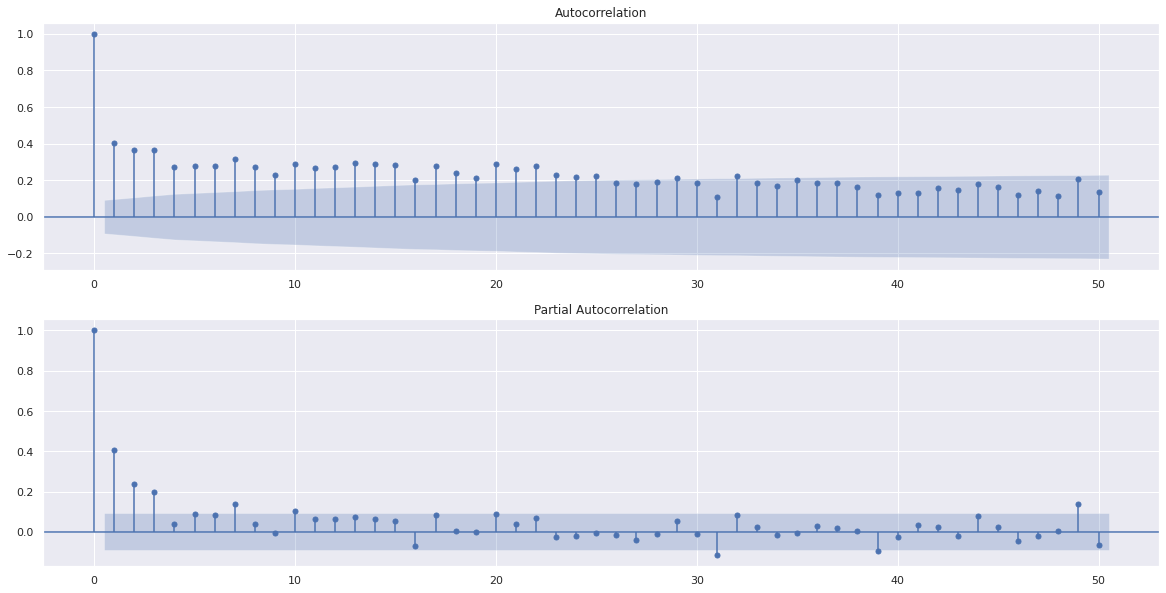

In [30]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(np.log(dff['TOTAL']), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(dff['TOTAL']), lags=50, ax=ax[1])
plt.show()

In [31]:
# feature creation
data=data.set_index('DATE')

In [32]:
data.PRICE.value_counts()

4.0    507
2.0     28
1.0     13
Name: PRICE, dtype: int64

In [33]:
def discount(x):
    if x==4:
        return 0
    if x==2:
        return 0.5
    if x==1:
        return 0.75

In [34]:
data['offer']=data['PRICE'].map(lambda x:1 if x<4 else 0)
data['discount']=data['PRICE'].apply(discount)

In [35]:
data=data[1:]
data.head()

,PRICE,PRICINGPOLICY,MARKETINGEVENT,TOTAL,offer,discount
DATE,,,,,,
2015-04-04,4.0,LIST PRICE,LAUNCH CAMPAIGN,1220.0,0,0.0
2015-04-05,4.0,LIST PRICE,LAUNCH CAMPAIGN,1444.0,0,0.0
2015-04-06,4.0,LIST PRICE,LAUNCH CAMPAIGN,1652.0,0,0.0
2015-04-07,4.0,LIST PRICE,LAUNCH CAMPAIGN,2004.0,0,0.0
2015-04-08,4.0,LIST PRICE,LAUNCH CAMPAIGN,2788.0,0,0.0


In [36]:
#train_test_split
train_start,train_end = '2015-04-04','2016-06-02'
test_start,test_end = '2016-06-03','2016-10-01'
train = data[train_start:train_end]
test = data[test_start:test_end]

In [37]:
sarimax = sm.tsa.statespace.SARIMAX(np.log(train['TOTAL']),order=(2,0,0),seasonal_order=(0,1,1,7),exog = train[['PRICE','discount','offer']],
                                enforce_stationarity=False, enforce_invertibility=False,freq='D').fit()
sarimax.summary()

C:\Users\nikit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               TOTAL   No. Observations:                  426
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 7)   Log Likelihood                 430.337
Date:                             Fri, 26 Nov 2021   AIC                           -846.674
Time:                                     20:11:06   BIC                           -818.544
Sample:                                 04-04-2015   HQIC                          -835.546
                                      - 06-02-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRICE          0.0305      0.011      2.782      0.005       0.009       0.052
discount      -0.0084      0.003     -3.049      0.002      -0.014      -0.003
offer          1.5611      0.028     55.628      0.000       1.506       1.616
ar.L1          0.3564      0.032     11.276      0.000       0.294       0.418
ar.L2          0.5147      0.026     20.056      0.000       0.464       0.565
ma.S.L7       -0.9025      0.037    -24.290      0.000      -0.975      -0.830
sigma2         0.0071      0.000     19.831      0.000       0.006       0.008
===================================================================================
Ljung-Box (L1) (Q):                   8.09   Jarque-Bera (JB):               288.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.36e+16. Standard errors may be unstable.
"""

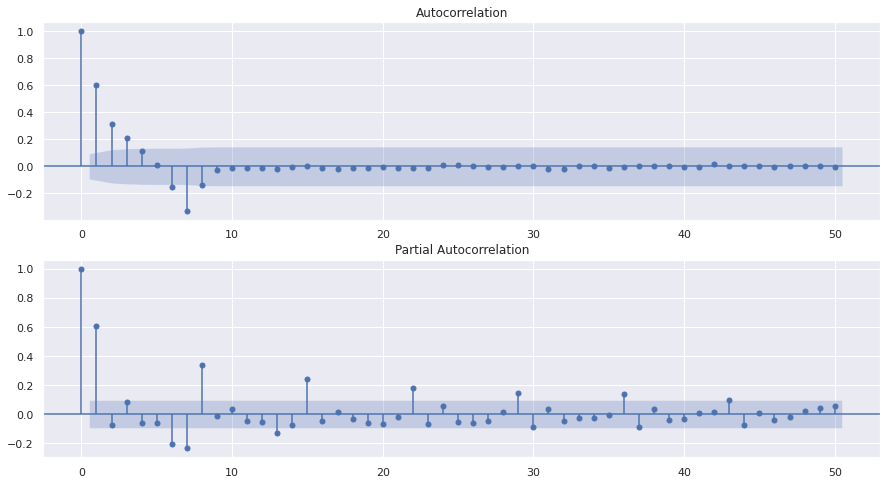

In [38]:
res = sarimax.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [39]:
train.tail()

,PRICE,PRICINGPOLICY,MARKETINGEVENT,TOTAL,offer,discount
DATE,,,,,,
2016-05-29,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,14464.0,0,0.0
2016-05-30,2.0,50% OFF,MINOR EVENT SPONSORSHIP,78810.0,1,0.5
2016-05-31,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,13908.0,0,0.0
2016-06-01,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,14504.0,0,0.0
2016-06-02,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,18068.0,0,0.0


In [40]:
## Full training data prediction

In [41]:
from sklearn.metrics import mean_squared_error
pred = sarimax.predict('2015-04-04','2016-06-02',exog = train[['PRICE','discount','offer']])
# print('SARIMAX model MSE:{}'.format(mean_squared_error(test['TOTAL'],np.exp(pred))))

C:\Users\nikit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


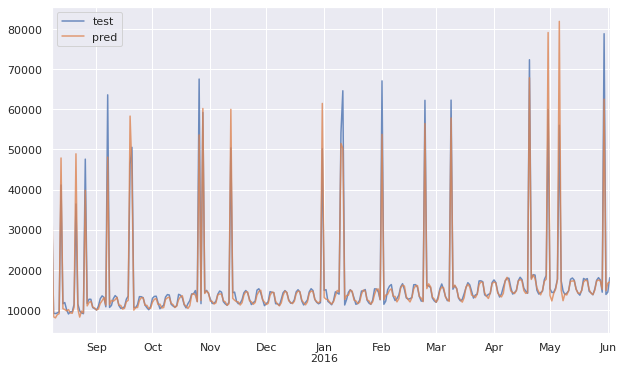

In [42]:
pd.DataFrame({'test':train['TOTAL'][-300:],'pred':np.exp(pred)[-300:]}).plot(figsize=(10,6),alpha=0.8)
plt.show()

In [43]:
test.head(30)

,PRICE,PRICINGPOLICY,MARKETINGEVENT,TOTAL,offer,discount
DATE,,,,,,
2016-06-03,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,17840.0,0,0.0
2016-06-04,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,17328.0,0,0.0
2016-06-05,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,14496.0,0,0.0
2016-06-06,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,13756.0,0,0.0
2016-06-07,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,14284.0,0,0.0
2016-06-08,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,14492.0,0,0.0
2016-06-09,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,17332.0,0,0.0
2016-06-10,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,18104.0,0,0.0
2016-06-11,4.0,LIST PRICE,MINOR EVENT SPONSORSHIP,17404.0,0,0.0


In [44]:
## Test data prediction and comparision
from sklearn.metrics import mean_squared_error
pred_test = sarimax.predict('2016-06-03','2016-07-02',exog = test[['PRICE','discount','offer']][:30])
print('SARIMAX model MSE:{}'.format(mean_squared_error(test['TOTAL'][:30],np.exp(pred_test))))

SARIMAX model MSE:7905261.482465763


C:\Users\nikit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


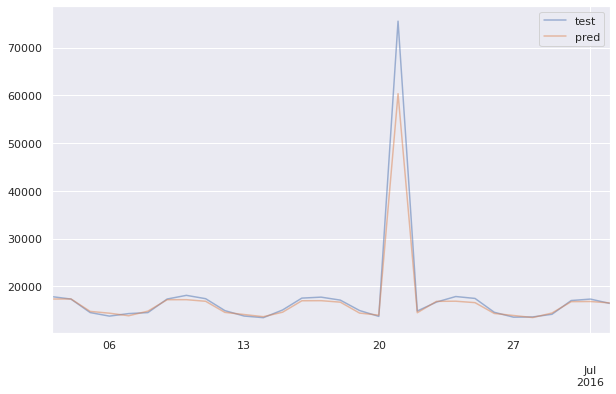

In [45]:
pd.DataFrame({'test':test['TOTAL'][:30],'pred':np.exp(pred_test)}).plot(figsize=(10,6),alpha=0.5)
plt.show()

C:\Users\nikit\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


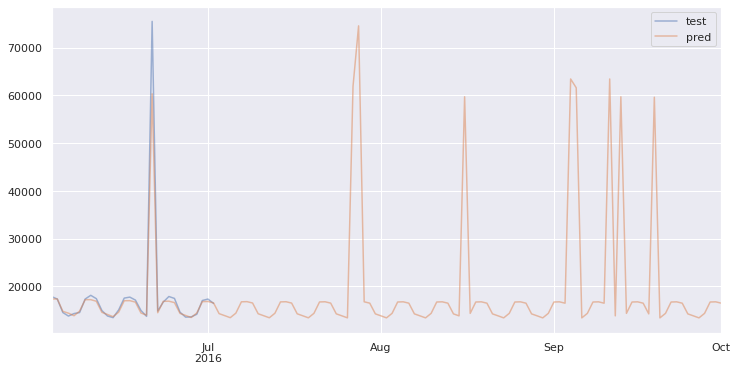

In [46]:
## Out of Sample prediction for 3 month upto 1/10/2016

pred_out = sarimax.predict('2016-06-03','2016-10-01',exog = test[['PRICE','discount','offer']])
pd.DataFrame({'test':test['TOTAL'],'pred':np.exp(pred_out)}).plot(figsize=(12,6),alpha=0.5)
plt.show()

In [47]:
# sarimax.plot_diagnostics(figsize=(15, 6))

C:\Users\nikit\AppData\Local\Temp/ipykernel_16408/646498429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['sx_total_pred']=np.exp(pred_test)


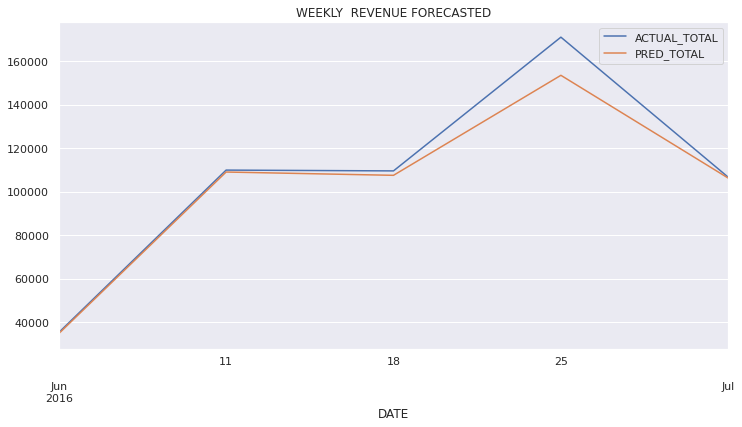

In [48]:
# weeklty prediction
test1=test[:30]
test1['sx_total_pred']=np.exp(pred_test)
week_act=pd.DataFrame()
week_pred=pd.DataFrame()
week_act['ACTUAL_TOTAL']=test1['TOTAL']
week_pred['PRED_TOTAL']=test1['sx_total_pred']
week_act=week_act.reset_index() 
week_pred=week_pred.reset_index()
week_act=week_act.groupby([ pd.Grouper(key='DATE', freq='W-SAT')])['ACTUAL_TOTAL'].sum().reset_index()
week_pred=week_pred.groupby([ pd.Grouper(key='DATE', freq='W-SAT')])['PRED_TOTAL'].sum().reset_index()
week_act['PRED_TOTAL']=week_pred['PRED_TOTAL']
week_act.set_index('DATE').plot(figsize=(12,6))
plt.title("WEEKLY  REVENUE FORECASTED")
plt.show()

In [49]:
## Out of sample Forecasting for next 3 months

<AxesSubplot:xlabel='DATE'>

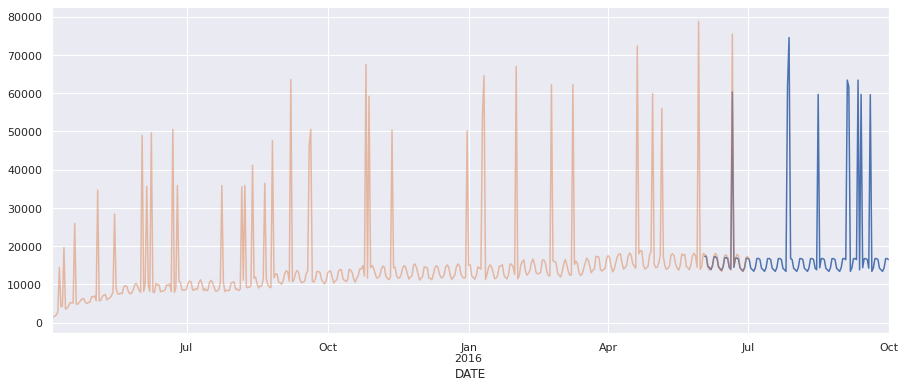

In [50]:
np.exp(pred_out).plot(figsize=(15,6))
data.TOTAL.plot(figsize=(15,6),alpha=0.5)

In [51]:
## Writing csv file of out of sample forecast


In [52]:
ps_1=test
ps_1=ps_1['2016-07-03':]
ps_1['Predicted_Revenue']=np.exp(pred_out)
ps_1=ps_1.reset_index()
weekly_revenue=ps_1.groupby([ pd.Grouper(key='DATE', freq='W-SAT')])['Predicted_Revenue'].sum().reset_index()

C:\Users\nikit\AppData\Local\Temp/ipykernel_16408/2070268147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ps_1['Predicted_Revenue']=np.exp(pred_out)


In [53]:
ps_1.head(7).Predicted_Revenue.sum()

105917.06094740263

In [54]:
sol_1=pd.read_csv('problem-one-sample-answer.csv',header=None)
sol_1[2]=weekly_revenue['Predicted_Revenue']
sol_1.to_csv('problem-one-answer.csv',header=False,index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'problem-one-sample-answer.csv'

In [ ]:
############################################################END#################################################################